In [37]:
import warnings
import numpy as np
import pandas as pd
import os
import re

import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, find_peaks_cwt
from scipy.integrate import trapezoid

# Suppress pandas warnings
warnings.filterwarnings('ignore')

# Settings
do_plots = True



In [2]:
# Functions

def extract_all_sheets(file_path):
    excel_file = pd.ExcelFile(file_path)
    sheet_names = excel_file.sheet_names
    
    all_data = [excel_file.parse(sheet_name, header = None) for sheet_name in sheet_names]
    
    return all_data

def get_spreadsheet_coords(df, label):
    """
    Accepts either a single label or a list
    """
    if type(label) is str:
        x_ind, y_ind = np.where(mineral_df == label)
        return x_ind[0], y_ind[0]

    elif type(label) is list:
        x_ind = []
        y_ind = []
        for list_val in label:
            x, y = np.where(df == list_val)
            x_ind.append(x[0])
            y_ind.append(y[0])
        return np.asarray(x_ind), np.asarray(y_ind)


def get_val_list(df,
                 val_name):
    # Identify how many features we have here
    start_x, start_y = get_spreadsheet_coords(df, val_name)
    val_list = []
    for i in range(start_x +1, df.shape[0]):
        curr_val = df.iloc[i , start_y]
        if i >= df.shape[0]:
            break
        elif not pd.isna(curr_val):
            val_list.append(curr_val)
        else:
            break
    
    print(f"Found {len(val_list)}: {val_list}")
    return val_list

def get_mask_from_waves(wav_array, wav_min, wav_max):
   return (wav_array >= wav_min) * (wav_array <= wav_max)

def generate_linear_regression(X, Y):
    # Convert from Series if necessary
    if type(X) != np.ndarray:
        X = np.asarray(X)
    if type(Y) != np.ndarray:
        Y = np.asarray(Y)    
    # Calculate the slope and intercept for the linear regression
    slope = (Y[-1] - Y[0]) / (X[-1] - X[0])
    intercept = Y[0] - slope * X[0]

    # Generate x values between the first and final points
    x_values = np.linspace(X[0], X[-1], num=len(X))

    # Generate y values using the linear regression equation
    y_values = slope * x_values + intercept

    return x_values, y_values

def parse_mineral_sheet(mineral_df):
    """
    """
    mineral_x, mineral_y = get_spreadsheet_coords(mineral_df, 'Mineral')
    
    # Identify which mineral we're parsing
    curr_mineral = mineral_df.iloc[mineral_x, mineral_y+1]
    print(f"Current mineral: {curr_mineral}")
    
    feature_list = get_val_list(mineral_df,
                                'Feature #')
    
    # Do the same thing for shapes
    region_list = get_val_list(mineral_df,
                                'Region #')
    
    # Note that this matches wrong for sheet 1 right now. 
    # we'll need to double check at a later stage of parsing
    # whether the rows have proper values or not, should be easy
    # using pd.isna
    
    # Do the same thing for shapes
    criteria_list = get_val_list(mineral_df,
                                'Criteria #')
    
    # Do the same thing for final weights
    overall_list = get_val_list(mineral_df,
                                'Overall weighting')

    return feature_list, region_list, criteria_list, overall_list

def parse_feature_list(feature_list, mineral_df):

    # Retrieve features to include
    fx,fy = get_spreadsheet_coords(mineral_df, feature_list)
    
    feature_subset_df = mineral_df.iloc[fx, :]
    incl_features_df = feature_subset_df[feature_subset_df[1] == 'include']
    excl_features_df = feature_subset_df[feature_subset_df[1] == 'exclude']

    return incl_features_df, excl_features_df

def perform_least_squares_fit(Lc, Oc):
    n = len(Lc)

    # Calculate the necessary summations
    sigma_Oc = np.sum(Oc)
    sigma_Lc = np.sum(Lc)
    sigma_OcLc = np.sum(Oc * Lc)
    sigma_Oc_sq = np.sum(Oc**2)
    sigma_Lc_sq = np.sum(Lc**2)

    # Calculate the coefficients 'a' and 'b'
    a = (sigma_Oc - (sigma_Lc / n)) / n
    b = (sigma_OcLc - (sigma_Oc * sigma_Lc) / n) / (sigma_Lc_sq - (sigma_Lc**2) / n)

    # Calculate 'k' and 'F'
    k = a / (1 - a)
    b_prime = (sigma_OcLc - (sigma_Oc * sigma_Lc) / n) / (sigma_Oc_sq - (sigma_Oc**2) / n)
    F = np.sqrt(b * b_prime)

    return a, b, k, F

def make_single_feature_dict(curr_incl_features_df,
                             spectrum_x,
                             spectrum_y):
    # Prepare the output dict
    feature_dict = {}

    # Handle cases where we aren't in nanometers
    if min(spectrum_x) < 100:
        spectrum_x = spectrum_x * 1000

    
    # Loop the include features
    for incl_feature in range(curr_incl_features_df.shape[0]):
    # incl_feature = 2
        curr_feature = (curr_incl_features_df.iloc[incl_feature, :])
        curr_l_min = curr_feature[2]
        curr_l_max = curr_feature[3]

        
        curr_wav_mask = get_mask_from_waves(spectrum_x,
                                   curr_l_min,
                                   curr_l_max)

        curr_x = spectrum_x[curr_wav_mask]
        curr_y = spectrum_y[curr_wav_mask]
        
        # Generate the linear regression line
        x_values, y_values = generate_linear_regression(curr_x, curr_y)
        
        # Generate the continuum removed version
        curr_y_hull_ratio = curr_y/y_values

                # Generate the continuum removed version
        curr_y_hull_ratio = curr_y/y_values
    
        # Build the dict for the current feature
        curr_feat_dict = {}
        curr_feat_dict['spec_subset_x'] = curr_x
        curr_feat_dict['spec_subset_y'] = curr_y
        curr_feat_dict['spec_regression_x'] = x_values
        curr_feat_dict['spec_reggression_y'] = y_values
        curr_feat_dict['spec_hull_removed'] = curr_y_hull_ratio
        
        # Store all of this for the current feature
        this_feat_name = str(incl_feature) + '_' + curr_feature[0]
        feature_dict[this_feat_name] = curr_feat_dict
    
    return feature_dict
        

def make_feature_dict(curr_incl_features_df):

    # Prepare the output dict
    feature_dict = {}
    
    # Loop the include features
    for incl_feature in range(curr_incl_features_df.shape[0]):
    # incl_feature = 2
        curr_feature = (curr_incl_features_df.iloc[incl_feature, :])
        curr_l_min = curr_feature[2]
        curr_l_max = curr_feature[3]
        
        curr_wav_mask = get_mask_from_waves(wav_array,
                                   curr_l_min,
                                   curr_l_max)
        
        curr_x = wav_array[curr_wav_mask]
        curr_y = curr_pixel[curr_wav_mask]
        
        # Generate the linear regression line
        x_values, y_values = generate_linear_regression(curr_x, curr_y)
        
        # Generate the continuum removed version
        curr_y_hull_ratio = curr_y/y_values
    
        
        # Do the same thing for the reference data
        curr_ref_wav_mask = get_mask_from_waves(curr_ref.Wavelength,
                                   curr_l_min,
                                   curr_l_max)
        
        curr_ref_x = curr_ref.Wavelength[curr_ref_wav_mask]
        curr_ref_y = curr_ref.Reflectance[curr_ref_wav_mask]
        
        
        # Generate the linear regression line
        x_ref_values, y_ref_values = generate_linear_regression(curr_ref_x.values, 
                                                                curr_ref_y.values)
        
        # Generate the continuum removed version
        curr_ref_y_hull_ratio = curr_ref_y/y_ref_values
    
        # Build the dict for the current feature
        curr_feat_dict = {}
        curr_feat_dict['spec_subset_x'] = curr_x
        curr_feat_dict['spec_subset_y'] = curr_y
        curr_feat_dict['spec_regression_x'] = x_values
        curr_feat_dict['spec_reggression_y'] = y_values
        curr_feat_dict['spec_hull_removed'] = curr_y_hull_ratio
        # Add the same features for the reference
        curr_feat_dict['ref_subset_x'] = curr_ref_x
        curr_feat_dict['ref_subset_y'] = curr_ref_y
        curr_feat_dict['ref_regression_x'] = x_ref_values
        curr_feat_dict['ref_reggression_y'] = y_ref_values
        curr_feat_dict['ref_hull_removed'] = curr_ref_y_hull_ratio    
        # Store all of this for the current feature
        this_feat_name = str(incl_feature) + '_' + curr_feature[0]
        feature_dict[this_feat_name] = curr_feat_dict

    return feature_dict

def do_tetracorder_weighting(curr_feat_dict, curr_ref_y_hull_ratio):
    
    for i, feat_name in enumerate(curr_feat_dict):
    # i = 0
    # this_feat = curr_feat_dict[list(curr_feat_dict.keys())[0]]
        this_feat = curr_feat_dict[feat_name]
        # Retrieve the variables we need locally
        spec_hull_ratio = this_feat['spec_hull_removed']
        ref_hull_ratio = this_feat['ref_hull_removed']
        ref_subset_x = this_feat['ref_subset_x']
        curr_ref_y_hull_ratio = this_feat['ref_hull_removed']
        
        # Get the minimum length between the reference and spectrum
        # to interpolate to
        min_length = np.min((len(spec_hull_ratio), len(ref_hull_ratio)))
        
        # Interpolate for regression
        ref_y_hull_ratio_downsampled = np.interp(np.linspace(0, len(curr_ref_y_hull_ratio) - 1, min_length),
                                            np.arange(len(curr_ref_y_hull_ratio)), curr_ref_y_hull_ratio)
        
        # Fit the least squares
        a, b, k, F = perform_least_squares_fit(spec_hull_ratio,
                                               ref_y_hull_ratio_downsampled)
        
        # store F
        this_feat['F'] = F
    
        #TODO this isn't very efficient as noted in tetracorder this should happen before allother calculations so that it doesn't have to happen every spsectrum
        # Store AUC
        this_feat['AUC'] = trapezoid(ref_hull_ratio, ref_subset_x)
    
        # Store depth
        this_feat['ref_depth'] = ref_hull_ratio.min()
        this_feat['spec_depth'] = spec_hull_ratio.min()
    
        
        # Update the main dict
        curr_feat_dict[list(curr_feat_dict.keys())[i]] = this_feat
    
    # Loop through again and calculate the overall weighting
    area_array = np.empty(len(curr_feat_dict))
    fits_array = np.empty(len(curr_feat_dict))
    depth_array = np.empty(len(curr_feat_dict))
    
    for i, feat_name in enumerate(curr_feat_dict):
        this_feat = curr_feat_dict[feat_name]
        area_array[i] = this_feat['AUC']
        # Extract the Fit variable
        fits_array[i] = this_feat['F']
        # Extract the Depeth variable
        depth_array[i] = this_feat['spec_depth']
    
    
    area_weights = area_array / area_array.sum()
    
    weighted_fits = (fits_array * area_weights).sum()
    weighted_depths = (depth_array * area_weights).sum()
    weighted_fit_x_depth =  (fits_array * depth_array * area_weights).sum()

    return weighted_fits, weighted_depths, weighted_fit_x_depth, area_weights

def compute_EGO_Gaussian(lmbda, si, mu_i, sigma_i, k_i):
    # EGO Gaussian function
    return si * np.exp(-0.5 * ((lmbda - mu_i) ** 2 / (sigma_i - k_i * (lmbda - mu_i)) ** 2))

def is_between(val, min, max):
    if val >= min and val <= max:
        return True
    elif pd.isna(min) or pd.isna(max):
        return True
    else:
        return False 

,Product ID,Applicable Mineral Groups,Minima From,Minima To,Notes
1,sf-0900,"iron oxides (goethite, hematite)",820.0,980.0,No hull correction
2,sf-2520,carbonates,2490.0,2550.0,Need testing - likely no hull correction
4,sf-0660,molybdenite,645.0,675.0,hull corrected
5,sf-0800,REE,790.0,810.0,hull corrected
6,sf-1000,pyroxene,880.0,1150.0,hull corrected
7,sf-1400,"micas, clays",1370.0,1420.0,hull corrected
8,sf-1460,jarosite,1450.0,1490.0,hull corrected
9,sf-1480,alunite,1465.0,1500.0,hull corrected
10,sf-1550,epidote,1535.0,1565.0,hull corrected
11,sf-1760,sulphates,1710.0,1785.0,hull corrected



Selected the following row for analysis:



Product ID                               sf-2380
Applicable Mineral Groups    amphiboles, biotite
Minima From                               2375.0
Minima To                                 2415.0
Notes                             hull corrected
Name: 21, dtype: object

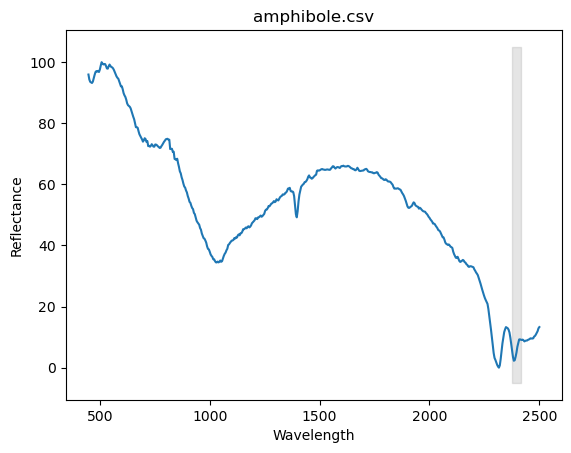

In [45]:
# Let's start by ingesting the criteria we've gotten from Cari
criteria_df = pd.read_excel('master_list.xlsx')
criteria_df.dropna(inplace=True)
display(criteria_df)
# This is going to be pretty manual, so let's select a given mineral and then a reference for that mineral to treat it 
curr_row = criteria_df.iloc[19,:]
print('')
print('Selected the following row for analysis:')
print('')
display(curr_row)

input_directory = 'reference_lib/'
curr_input_file = 'amphibole.csv'
curr_input = pd.read_csv(os.path.join(input_directory, curr_input_file))
if do_plots:
    plt.plot(curr_input.iloc[:,0], curr_input.iloc[:,1])
    plt.title(curr_input_file)
    plt.xlabel('Wavelength')
    plt.ylabel('Reflectance')
    
    # Add a shaded region to show the ROI
    plt.fill_between([curr_row['Minima From'], curr_row['Minima To']], plt.ylim()[0], plt.ylim()[1], color='gray', alpha=0.2)

In [47]:
spectrum_x = curr_input.iloc[:,0]
spectrum_y = curr_input.iloc[:,1]

curr_wav_mask = get_mask_from_waves(spectrum_x, curr_row['Minima From'], curr_row['Minima To'])
curr_wavs = spectrum_x[curr_wav_mask]
curr_peak = 


# curr_wavs = this_feat_dict[this_feat]['spec_subset_x']
# curr_peak = 1 - this_feat_dict[this_feat]['spec_hull_removed']